In [1]:
from pytket import Circuit
from pytket.circuit import OpType, Op
from pytket.circuit.display import render_circuit_jupyter
from pytket_dqc.networks import NISQNetwork
from pytket_dqc.allocators import HypergraphPartitioning
from pytket_dqc.circuits import HypergraphCircuit
from pytket_dqc.packing import PacMan
from pytket_dqc.utils import DQCPass
from pytket_dqc.placement import Placement
from sympy import Symbol
import networkx as nx
import matplotlib.pyplot as plt
import json

In [11]:
# Replace this with the location of the Chemistry circuit.
with open("../../Tokyo-CQC-collab/circuits/uccsd/raw/06_02_01.json") as f:
    circuit = Circuit.from_dict(json.load(f))

n_qubits = len(circuit.qubits)
    
serv0 = circuit.qubits[:int(n_qubits / 2)]
serv1 = circuit.qubits[int(n_qubits / 2):]
        
network = NISQNetwork(
    [[0,1]],
    {0: [x for x in range(int(n_qubits / 2))], 1: [x for x in range(int(n_qubits / 2), n_qubits)]}
)

# Bind all the symbols in the circuit
symbol_map = dict()
for symbol in circuit.free_symbols():
    symbol_map[Symbol(symbol.__repr__())] = 1
circuit.symbol_substitution(symbol_map)
# Check they're all bound
print(circuit.free_symbols())

render_circuit_jupyter(circuit)

set()


In [12]:
DQCPass().apply(circuit)
non_local = 0

for command in circuit.get_commands():
    if command.op.type != OpType.CU1:
        continue
    
    if command.args[0] in serv0 and command.args[1] in serv1:
        non_local += 1
    elif command.args[1] in serv0 and command.args[0] in serv1:
        non_local += 1

print(non_local)

allocator = HypergraphPartitioning()
distribution = allocator.allocate(circuit, network)
hypergraph_circuit = HypergraphCircuit(circuit)
render_circuit_jupyter(circuit)

76


In [13]:
pacman_chem = PacMan(hypergraph_circuit, distribution.placement)

In [15]:
print(len(pacman_chem.get_mvc_merged_graph()))

74


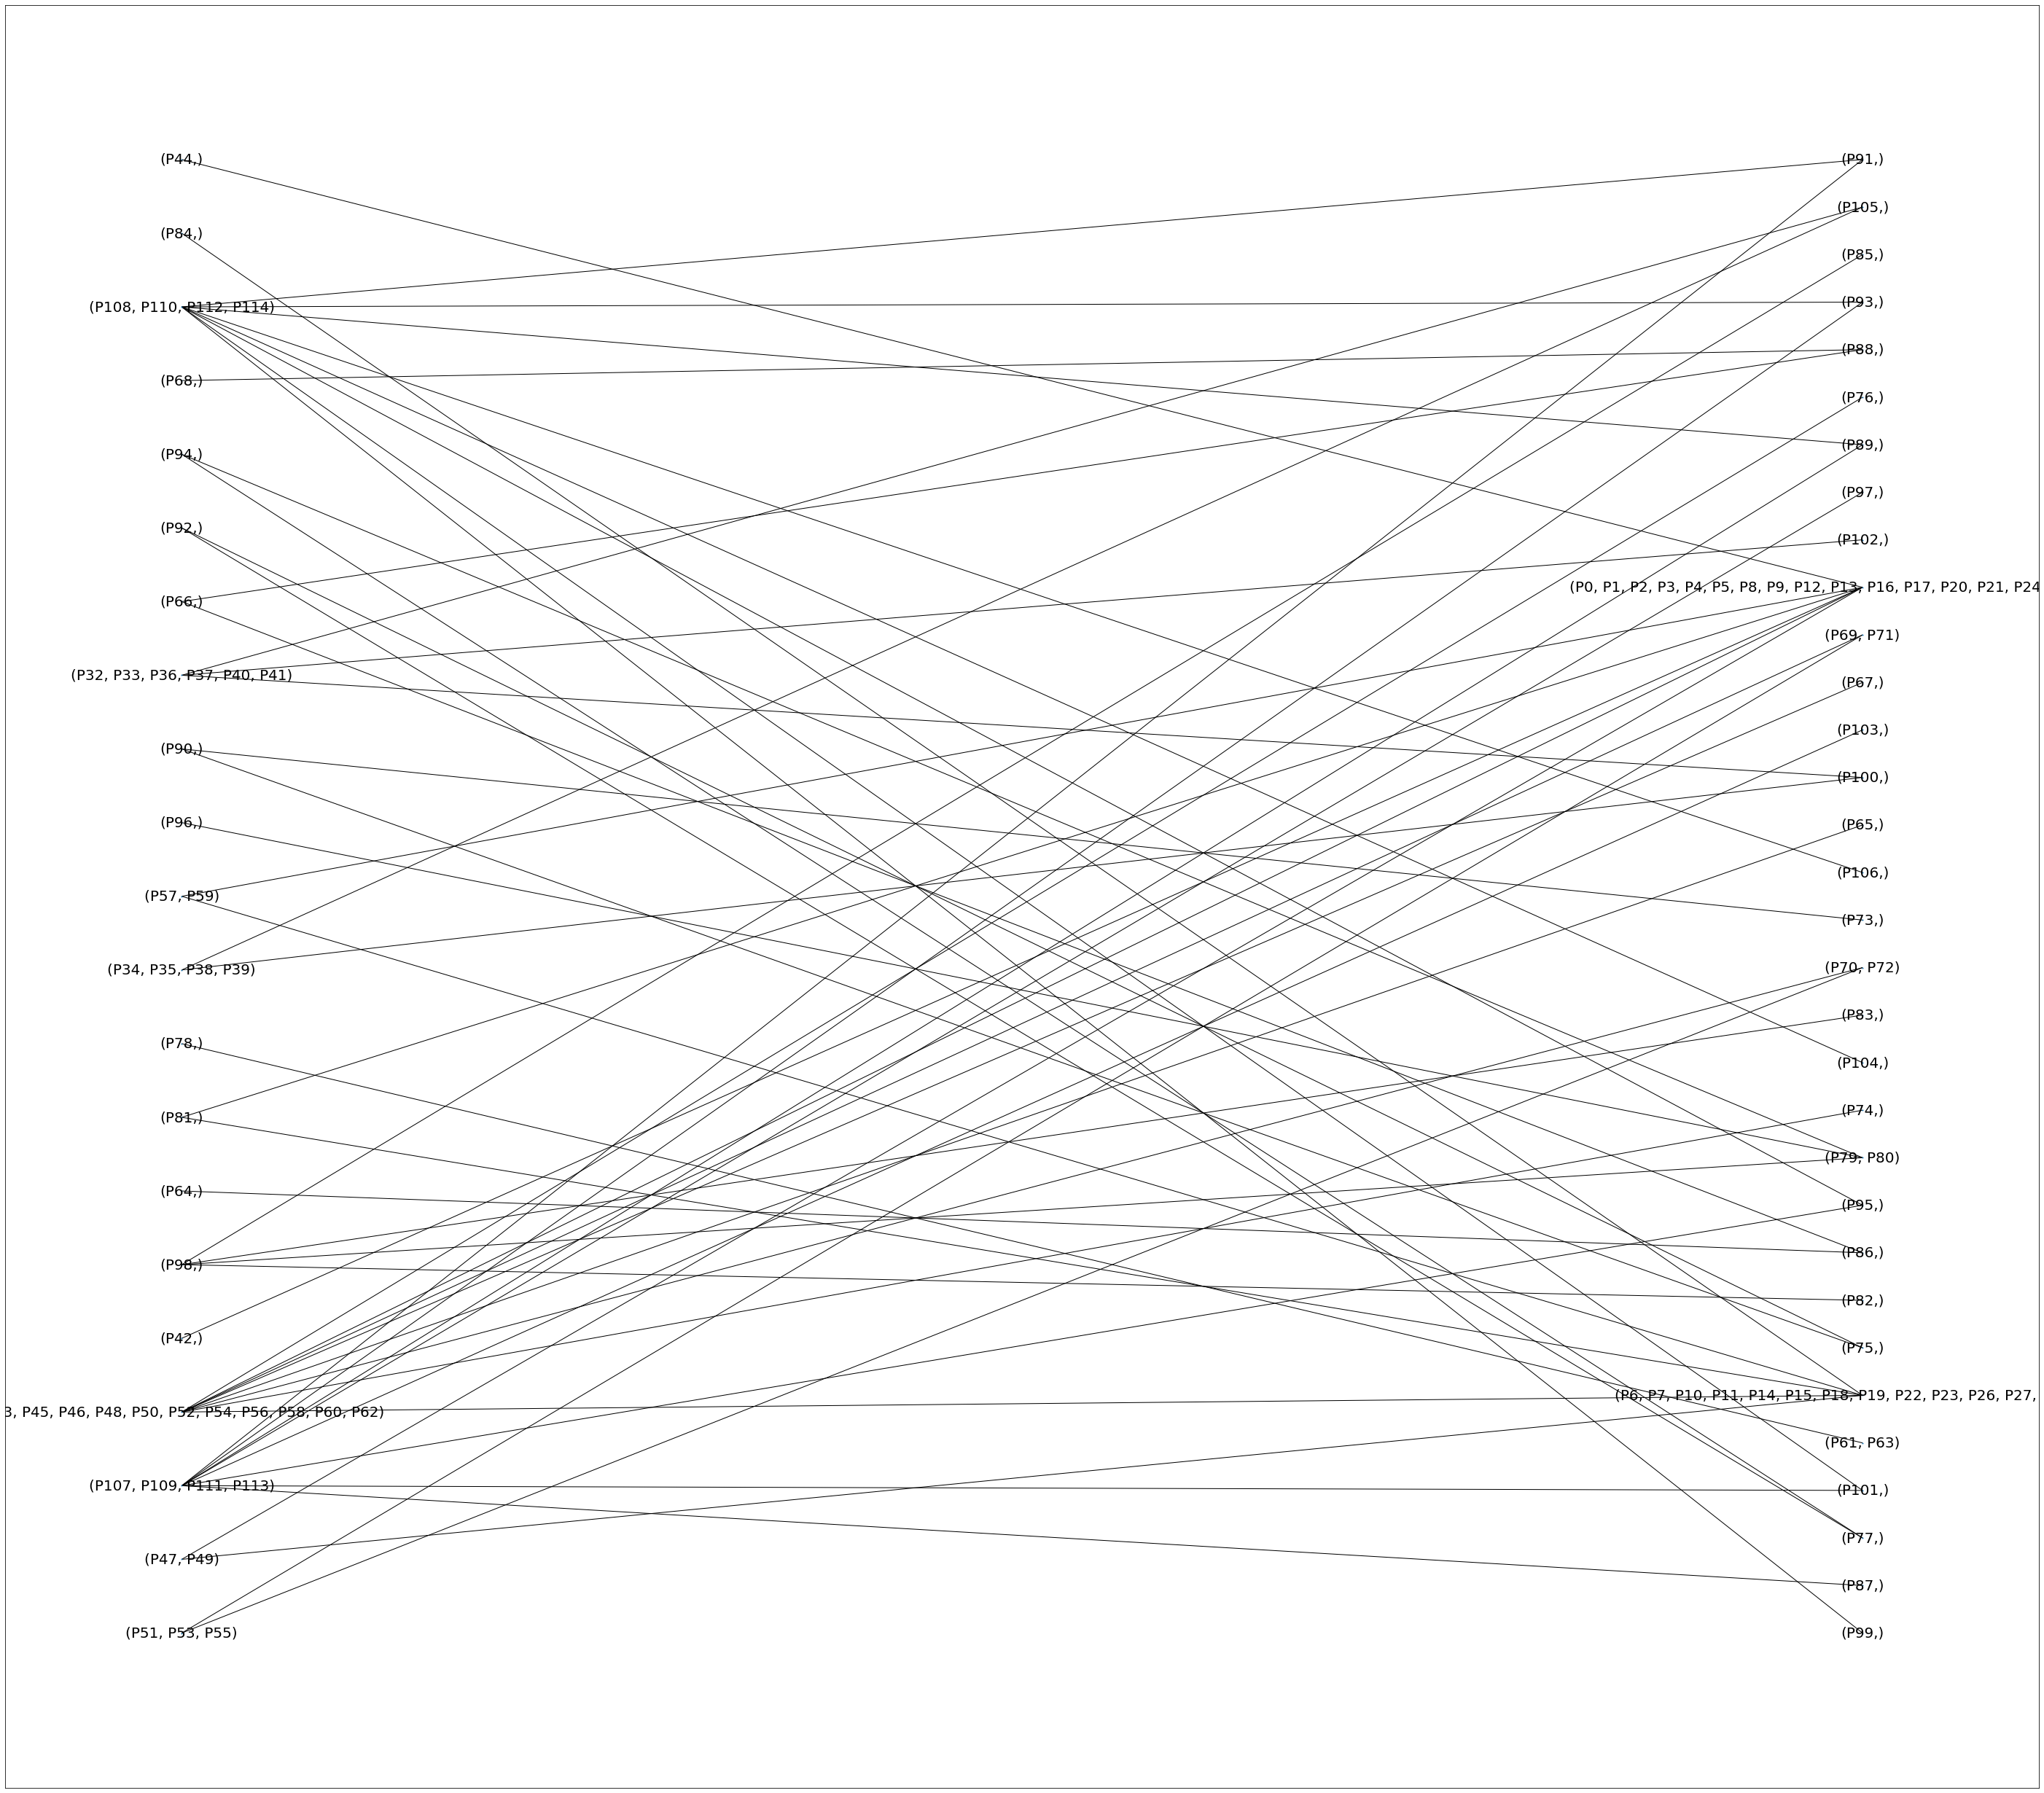

In [6]:
g_chem, topnodes_chem = pacman_chem.get_nx_graph_merged()

plt.figure(3,figsize=(50,45)) 
nx.draw_networkx(
    g_chem,
    pos = nx.drawing.layout.bipartite_layout(g_chem, topnodes_chem), 
    width = 1,
    node_size=1,
    font_size=20,
    with_labels=True
)

In [7]:
nx.draw_networkx(
    conflict_g_chem,
    pos = nx.drawing.layout.bipartite_layout(conflict_g_chem, conflict_topnodes_chem), 
    width = 1)
print(len(pacman_chem.get_mvc_merged_graph()))

NameError: name 'conflict_g_chem' is not defined

In [ ]:
def get_packet(pacman, string_rep):
    for packet in pacman.get_all_packets():
        if packet.__repr__() == string_rep:
            return packet

print(get_packet(pacman_chem, "P88"))

In [ ]:
import sys
import numpy
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
numpy.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
merged_packets = pacman_chem.get_all_merged_packets()
print(nx.to_numpy_matrix(g_chem, nodelist = merged_packets))
print(merged_packets)

In [ ]:
print(nx.to_numpy_matrix(conflict_g_chem))
print(conflict_g_chem.nodes)

In [ ]:
hopping = list()
for i in range(6):
    hopping.extend(pacman_chem.hopping_packets[i])
print(hopping)